In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 16.1 char_rnn을 사용해 셰익스피어 문체 생성하기

시퀀스를 윈도우로 스플릿하기

In [ ]:
n_steps=5
dataset =tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps,2,drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
#원래 같은 경우 5 -> 4 -> 3 -> 처럼 iter 형식으로 받을 수 있었는데,
#flat_map을 사용하면 [5, 4, 3, 2, 1]로 바로 받을 수 있습니다.

dataset = dataset.shuffle(10).map(lambda window: (window[:-1],window[1:]))
dataset = dataset.batch(3).prefetch(1)

1~15를 윈도우 5, 쉬프트 2로 분할.

셔플

X,y set로 변환

In [ ]:
for index,(X_batch,Y_batch) in enumerate(dataset):
  print("_" *20,"Batch",index,"\nX_batch")
  print(X_batch.numpy())
  print("="*5, "\nY_batch")
  print(Y_batch.numpy())

### 16.1.1 훈련 데이터셋 만들기

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)

with open(filepath) as f:
  shakespeare_text = f.read()

In [ ]:
print(shakespeare_text[:100])

쓰인 문자들 추출

In [ ]:
"".join(sorted(set(shakespeare_text.lower())))

모든 글자 정수로 인코딩

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
#char_level=True 단어수준x 글자수준 인코딩
tokenizer.fit_on_texts(shakespeare_text)

In [ ]:
tokenizer.texts_to_sequences(["First"])

In [ ]:
tokenizer.sequences_to_texts([[20,6,9,8,3]])

In [ ]:
max_id = len(tokenizer.word_index) #고유 글자 수

In [ ]:
dataset_size = tokenizer.document_count #전체 글자 수 

In [ ]:
tokenizer.word_index

전체 텍스트를 인코딩하여 각 글자를 ID로 나타내기 (0부터 나타내기위해 -1)

In [ ]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text]))-1

In [ ]:
encoded.shape

### 16.1.2 순차 데이터셋을 나누는 방법

In [ ]:
train_size = dataset_size *90 //100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### 16.1.3 순차 데이터를 윈도 여러개로 자르기

In [ ]:
n_steps=100
window_length = n_steps+1 # 윈도우 다음 타깃까지.
dataset = dataset.repeat().window(window_length,shift=1,drop_remainder=True)

In [ ]:
batch_size=32

dataset = dataset.flat_map(lambda window : window.batch(window_length))

In [ ]:
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda window : (window[:,:-1],window[:,1:]))

원핫으로 바꾸기

In [ ]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [ ]:
dataset = dataset.prefetch(1)

### 16.1.4 char-RNN 모델을 만들고 훈련하기

In [ ]:
model = keras.models.Sequential([
                                #gpu만 사용하기 위해 상태드롭아웃 끔.
                                 keras.layers.GRU(128,dropout=0.2,#,recurrent_dropout=0.2
                                                  input_shape=[None,max_id],return_sequences=True),
                                 keras.layers.GRU(128,dropout=0.2,#recurrent_dropout=0.2,
                                                  return_sequences=True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(max_id))
                            
])

In [ ]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer = keras.optimizers.Adam())

history = model.fit(dataset,epochs=1,
                    steps_per_epoch=train_size // batch_size)

### 16.1.5 Char-RNN 모델 사용하기

새로운 인풋에 대해 전처리하여 새로운 글자 예측하기

In [ ]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts))-1
  return tf.one_hot(X,max_id)

In [ ]:
X_new = preprocess(["How are yo"]) #마지막 u 빼고
Y_pred = np.argmax(model.predict(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred+1)[0][-1] #예측 첫번째 문장 마지막 글자.


In [ ]:
y_proba = model.predict( preprocess(["How are yo"]))
y_proba.shape
#(1, 10, 39) 하나의 배치. 10개의 아웃풋. 각각 39개의 문자 확률.

### 16.1.6 가짜 셰익스피어 텍스트 생성하기

In [ ]:
def next_char(text, temperature=1):
  X_new = preprocess([text])
  Y_proba = model.predict(X_new)[0,-1:,:]
  #첫번째예시, 마지막 아웃풋, 39개 문자 확률전부 
  rescaled_logits = tf.math.log(Y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) +1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
print(complete_text("t", temperature=1))
print(complete_text("t", temperature=0.2))
print(complete_text("t", temperature=2))

### 16.1.7 상태가 있는 RNN

상태가 있는 RNN은 순차적이고 겹치지 않는 입력 시퀀스를 만들어야함.

각각 배치의 마지막 상태를 다음 배치의 초기상태로 사용하기 위해.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [ ]:
dataset

In [ ]:
dataset = dataset.window(window_length,shift=n_steps,drop_remainder=True)
dataset = dataset.flat_map(lambda window : window.batch(window_length))
dataset = dataset.repeat().batch(1)

In [ ]:
dataset=  dataset.map(lambda window : (window[:,:-1], window[:,1:]))

In [ ]:
dataset = dataset.map(
    lambda X_batch,Y_batch : (tf.one_hot(X_batch,depth=max_id),Y_batch)
)
dataset.prefetch(1)

위 방법은 배치로는 못만들었음. 하지만 상태가 있는 RNN모델은 배치가 필요함.

배치로 만들면서 겹치지 않는 입력 시퀀스 만들기

In [ ]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
##
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
##
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
dataset

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, #recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))])
#콜백을 이용해 에폭마다 텍스트를 다시 시작하기 전에 상태를 재설정
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

#배치마다 샘플은 1개.
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

# 16.2 감성분석

In [ ]:
(X_train,y_train), (X_test,y_test)  = keras.datasets.imdb.load_data()

In [ ]:
X_train.shape

이미 전처리돼어 있는 데이터셋 --> 넘파이 정수배열. 많을수록 낮은 인덱스

In [ ]:
X_train[0][:10]

인덱스를 단어로 바꾸어 확인해보기 위해 불러옴

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

In [ ]:
word_index

In [ ]:
sorted(word_index.items(), key= lambda x: x[1])[-10:]

패딩토큰, 시퀀스시작토큰, 언노운 토큰 추가하기

In [ ]:
id_to_word = {id_+3: word for word, id_ in word_index.items()}

for id_,token in enumerate(("<pad>","<sos>","<unk>")):
  id_to_word[id_]=token

In [ ]:
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

In [ ]:
y_train[0]

이번엔 직접 전처리 해보기.

동일한 데이터셋을 tfds에서 바이트 스트링으로 받아옴

In [ ]:
import tensorflow_datasets as tfds

datasets,info = tfds.load("imdb_reviews",as_supervised=True,
                          with_info=True)

In [ ]:
datasets.keys()

In [ ]:
info

In [ ]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [ ]:
train_size,test_size

In [ ]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

전처리함수

In [ ]:
def preprocess(X_batch,y_batch):
  X_batch = tf.strings.substr(X_batch,0,300)
  #300단어까지만 짜름
  X_batch = tf.strings.regex_replace(X_batch,rb"<br\s*/?>", b" ")
  #br을 공백으로
  X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
  #단어랑 작은따옴표 아니면 공백으로
  X_batch = tf.strings.split(X_batch)
  #스플릿을 통해 래그드텐서 반환
  return X_batch.to_tensor(default_value=b"<pad>"),y_batch
  #빈공간을 pad토큰으로 하여 밀집텐서로 바꿈.

In [ ]:
preprocess(X_batch,y_batch)

어휘사전 구축

In [ ]:
from collections import Counter

vocabulary = Counter()
for X_batch,y_batch in datasets["train"].batch(32).map(preprocess):
  for review in X_batch:
    vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common()[:3]

In [ ]:
len(vocabulary)

어휘사전 크기 10000개로

In [ ]:
vocab_size=10000

truncated_vocabulary=[
                     word for word,count in vocabulary.most_common()[:vocab_size]
]

In [ ]:
len(truncated_vocabulary)

In [ ]:
truncated_vocabulary[:10]

각 단어를 id로 바꾸기

In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary),dtype = tf.int64)

#룩업테이블 만들기
vocab_init = tf.lookup.KeyValueTensorInitializer(words,word_ids)

#out of bucket 1000개로 설정.
num_oov_buckets=1000
table = tf.lookup.StaticVocabularyTable(vocab_init,num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))
#faaaaaantasic은 룩업테이블에서 oov이기 떄문에 10000보다 큼

In [ ]:
def encode_words(X_batch,y_batch):
  return table.lookup(X_batch),y_batch

In [ ]:
train_set = datasets["train"].repeat().batch(32).map(preprocess) #preprocess : 지우고 패딩하고.
train_set = train_set.map(encode_words).prefetch(1)

In [ ]:
for X_batch,y_batch in train_set.take(1):
  print(X_batch)
  print(y_batch)

In [ ]:
embed_size= 128

model= keras.models.Sequential([
                                keras.layers.Embedding(vocab_size+num_oov_buckets,
                                                       128,
                                                       input_shape=[None]),
                                keras.layers.GRU(128,return_sequences=True),
                                keras.layers.GRU(128),
                                keras.layers.Dense(1,activation="sigmoid")
])

In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer= keras.optimizers.Adam(),
              metrics =["accuracy"])

In [ ]:
history = model.fit(train_set,steps_per_epoch=train_size//32,epochs=5)

16.2.1 마스킹

pad와 같이 무시해야 결과가 잘나오는 경우 마스킹을 통해 무시할수있음.

In [ ]:
truncated_vocabulary[:10]

간편하게 마스킹 하는법. 패딩토큰(0) 무시

조건: 모든 레이어가 마스킹을 지원해야함

mask_zero = True

In [ ]:
model =keras.models.Sequential([
                                keras.layers.Embedding(vocab_size+num_oov_buckets,
                                                       embed_size,
                                                       mask_zero=True),
                                keras.layers.GRU(128,return_sequences=True),
                                keras.layers.GRU(128),
                                keras.layers.Dense(1, activation="sigmoid")
])


model.compile(loss = keras.losses.binary_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ["accuracy"])

history = model.fit(train_set, steps_per_epoch=train_size//32,
                    epochs=5)


conv층과 섞는 등 복잡한 모델에서는 mask_zero가항상 작동하지 않음.

수동으로 마스크를 전달해 줘야함.

In [ ]:
K= keras.backend

inputs = keras.layers.Input(shape=[None])
#마스킹 층.
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs,0))(inputs)

z= keras.layers.Embedding(vocab_size+num_oov_buckets, embed_size)(inputs)
z= keras.layers.GRU(128,return_sequences=True)(z,mask=mask)#전달
z=keras.layers.GRU(128)(z,mask=mask)#전달

outputs = keras.layers.Dense(1, activation = 'sigmoid')(z)

model = keras.Model(inputs = [inputs],
                    outputs = [outputs])


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

### 16.2.2 사전훈련된 임베딩 재사용하기

텐서플로우 허브에서 사전훈련된 모델 컴포넌트를 모델에 추가할수있음

문장 인코더 받아오기.

내부구조: 문자열파싱, 단어 임베딩, 단어들의 평균으로 문장 임베딩

In [ ]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
                   #문장을 50차원의 벡터로 인코딩
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [ ]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

IMDB 리뷰 데이터셋 받기.

In [ ]:
import tensorflow_datasets as tfds


datasets, info = tfds.load("imdb_reviews",as_supervised=True,
                           with_info=True)

텐서플로우 허브에서 불러와 만든 모델로 바로 학습가능

In [ ]:
train_size = info.splits["train"].num_examples
batch_size=32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set,steps_per_epoch=train_size//batch_size, epochs=5)

# 16.3 신경망 기계 번역을 위한 인코더 - 디코더 네트워크

In [ ]:
tf.random.set_seed(42)

In [ ]:
vocab_size=100
embed_size=10

In [ ]:
import tensorflow_addons as tfa

In [ ]:
#학습을 위한 인코더, 디코더 인풋레이어
encoder_inputs = keras.layers.Input(shape=[None], dtype =np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype =np.int32)
sequence_length = keras.layers.Input(shape=[], dtype = np.int32)

embeddings = keras.layers.Embedding(vocab_size,embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs ,state_h, state_c = encoder(encoder_embeddings) #아웃풋, 단기, 장기
encoder_state = [state_h,state_c]

# 각 스텝에서 디코더에게 이전 스탭의 출력이 무엇인지 알려줌.
sampler= tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)




decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
# Basic sampling decoder for training and inference.
# The tfa.seq2seq.Sampler instance passed as argument is responsible to sample from
# the output distribution and produce the input for the next decoding step. The decoding
# loop is implemented by the decoder in its __call__ method.


final_outputs,final_state,final_sequence_length = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_length
)


Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.Model(inputs=[encoder_inputs,decoder_inputs,sequence_length],
                    outputs=[Y_proba])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [ ]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

### 16.3.1 양방향 RNN

하나는 왼쪽에서

하나는 오른쪽에서 단어를 읽고 합침

양방향 GRU 구현

Bidirectional은 층을 복사하여 두 층을 실행. 출력을 연결.

GRU층이 10개의 유닛을 가지면 20개의 값을 출력

In [ ]:
keras.layers.Bidirectional(keras.layers.GRU(10,return_sequences=True))

### 16.3.2 빔 검색

한가지 결과만 보지 않고, 

빔 너비 만큼 모델을 돌려 여러가지 결과를 입력에 대한 조건부 확률로 비교

In [ ]:
beam_width = 10
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell=decoder_cell,beam_width=beam_width, output_layer = output_layer
)

#인코더의 마지막 상태 복사
decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(
    encoder_state,multiplier=beam_width
)

# outputs,_,_ = decoder(
#     embedding_decoder,start_tokens=start_tokens,end_token = end_token,
#     initial_state = decoder_initial_state
# )



## 16.4 어텐션 메커니즘

https://wikidocs.net/22893

어텐션에 대한 설명

모든 인코더와 각각 디코더 셀을 연결하여 어떤 인코더(단어) 에 집중해야 하는지 가중치a를 계산

긴 sequence에 대한 해결.

디코더 셀을 AttentionWrapper 클래스로 감싸고 원하는 어텐션 메커니즘을 지정


In [ ]:
# #어텐션 메커니즘
# attention_mechanism = tfa.seq2seq.attention_wrapper.LuongAttention(
#      units,encoder_state,memory_sequence_length=encoder_sequence_length
#  )
# #어텐션 래퍼

# attention_decoder_cell = tfa.seq2seq.attention_wrapper.AttentionWrapper(
#      decoder_cell, attention_mechanism, attention_layer_size =n_units
#  )

### 16.4.1 비주얼 어텐션

합성곱신경망을 통과시켜 특성맵추출.

어텐션 메커니즘을 장착한 디코더 rnn이 한번에 한 단어씩 캡션을 생성

타임스탭마다 어텐션모델을 사용해 적절한 부위에 초점을 맞춤.

설명가능성 있음

16.4.2 트랜스포머 구조: attention is all you need

https://wikidocs.net/31379

트랜스포머 구조에 대한 설명

임베딩 후, 위치 인코딩

In [ ]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

트랜스포머의 첫번째 층: 임베딩, 위치인코딩

In [ ]:
embed_size = 512
max_steps =500
vocab_size=10000

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype = np.int32)
embeddings = keras.layers.Embedding(vocab_size,embed_size)

encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

positional_encoding = PositionalEncoding(max_steps,embed_size)

encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)


층 정규화, 스킵연결, 피드포워드 모듈 등을 제외한 

간소화한 프랜스포머 구조(멀티헤드 구현 X, 스케일드 점곱)

In [ ]:
Z = encoder_in

for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z


Z = decoder_in

for N in range(6):
  Z = keras.layers.Attention(use_scale=True,causal=True)([Z,Z])
  Z = keras.layers.Attention(use_scale=True)([Z,encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size,activation="softmax")
)


# 연습문제 8. 임베딩된 레버문법 구별하기

임베딩된 레버문법 : "BPBTSXXVPSEPE."와 같은 문자열을 만드는 인공문법

a. 레버문법을 따르는 문자열을 생성하는 함수 만들기

기본 레버문법

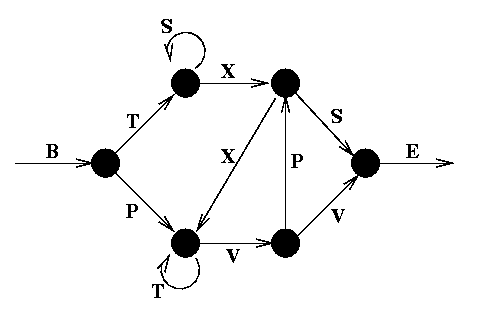

In [ ]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)


레버속 레버 임베딩

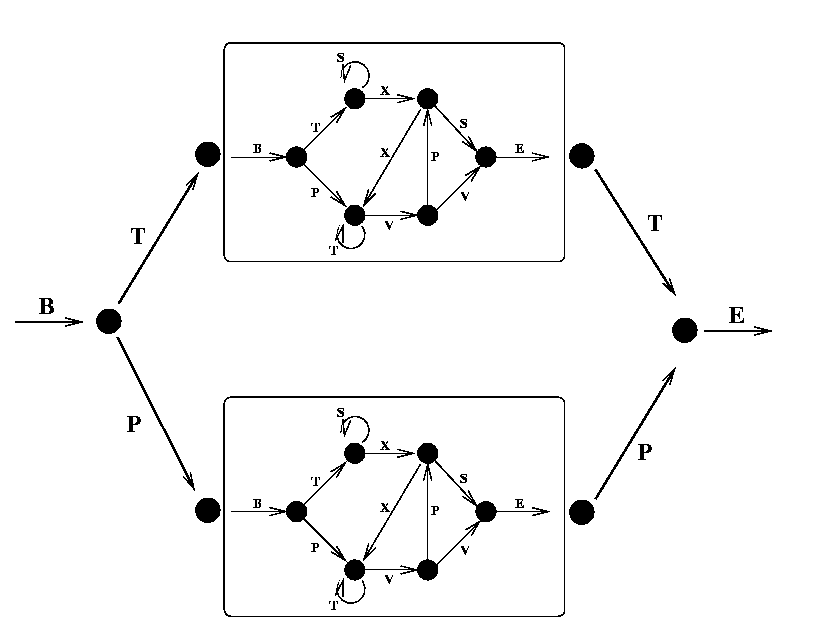

In [ ]:
embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

In [ ]:
def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        #현재 상태에서 가능한 상태 랜덤으로 고름. 
        index = np.random.randint(len(grammar[state]))
        #다음상태
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production) 3/13
        output.append(production)
    return "".join(output)

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

In [ ]:
for i in range(10,-1,-1):
  print(i)